<h4>Import des librairies necessaires au projet</h4>


In [354]:
import pandas as pd
import numpy as np
import math, re, os, cv2
import random
import gc
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from skimage.util import random_noise
from skimage.transform import rotate, AffineTransform, warp
import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [355]:
path = r'C:\Users\oussa\Desktop\PPP\noncloud\noncloud'
path2 = r'C:\Users\oussa\Desktop\PPP\cloud\cloud'

<h4>Chargement des données</h4>

In [356]:
all_images=[]
all_images1=[]
import os
img_list = os.listdir(path)
for i in tqdm(img_list):
    img = tf.keras.preprocessing.image.load_img(path+'/'+str(i), target_size=(64,64,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255.
    all_images.append(img)
    all_images1.append(img.flatten())
    
all_images= np.array(all_images[1:])
all_images.shape

100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:02<00:00, 678.07it/s]


(1499, 64, 64, 3)

In [357]:
all_images1=np.array(all_images1)
all_images1.shape

(1500, 12288)

<h4>Visionnage de quelques exemples des images</h4>

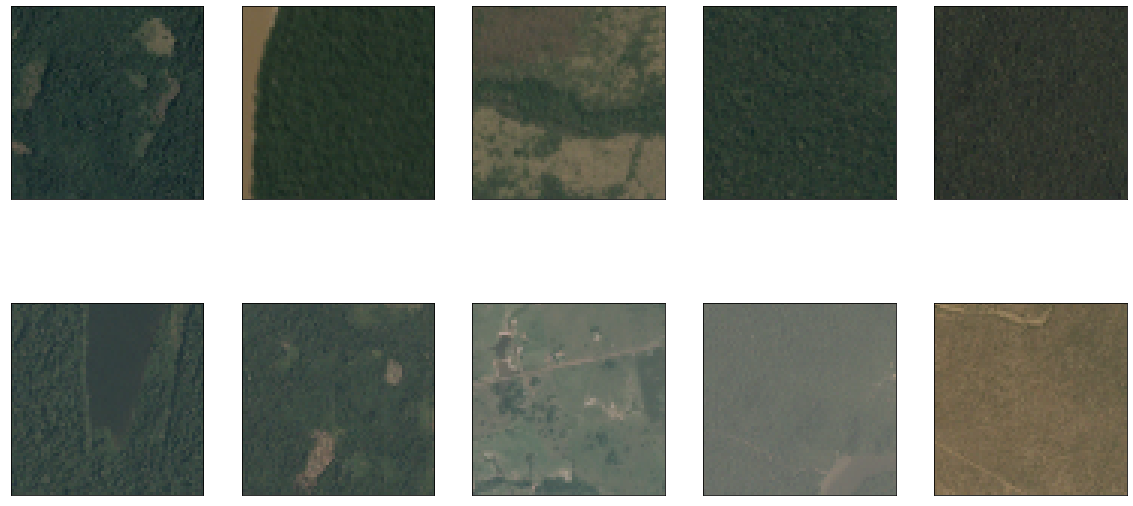

In [358]:
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(all_images[i+50])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(all_images[i+20])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

<h4>Définition de l'architecture de l'autoencodeur</h4>

In [359]:
import torch.nn as nn
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(64 * 64 * 3, 256), 
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32) 
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 64 * 64 * 3),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

<h4>Compilation de l'autoencodeur et definition de la fonction cout et de la fonction d'optimisation des paramètres</h4>

In [360]:
model = Autoencoder_Linear()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [387]:
X_train = torch.from_numpy(all_images1)

In [388]:
X_train.shape

torch.Size([1500, 12288])

<h4>Training de l'autoencodeur sur les données des images no cloud</h4>

In [364]:
num_epochs = 10
outputs = []
train_losses = []
history = []
for epoch in range(num_epochs):
    for (img) in X_train:
        #img = img.reshape(-1, 28*28*3)
        recon = model(img)
        loss = criterion(recon, img)
        train_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = np.mean(train_losses)

    history.append(train_loss)

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0024
Epoch:2, Loss:0.0024
Epoch:3, Loss:0.0022
Epoch:4, Loss:0.0028
Epoch:5, Loss:0.0019
Epoch:6, Loss:0.0019
Epoch:7, Loss:0.0019
Epoch:8, Loss:0.0019
Epoch:9, Loss:0.0018
Epoch:10, Loss:0.0019


<h4>Visualtion du cout au cours du training, on remarque que le modele converge </h4>

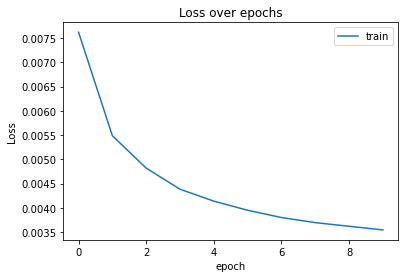

In [366]:

ax = plt.figure().gca()
ax.plot(history)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train'])
plt.title('Loss over epochs')
plt.show();

<h4>Chargement des données qui reprèsentent l'anomalie (Cloud images)</h4>

In [404]:
cloud_images=[]
cloud_images_toplot=[]
import os
img_list = os.listdir(path2)
for i in tqdm(img_list):
    img = tf.keras.preprocessing.image.load_img(path2+'/'+str(i), target_size=(64,64,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255.
    cloud_images.append(img.flatten())
    cloud_images_toplot.append(img)
    


100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 741.19it/s]


In [405]:
cloud_images=np.array(cloud_images)
cloud_images.shape

(48, 12288)

<h4>Visualisation de quelques échantillons de Cloud images</h4>

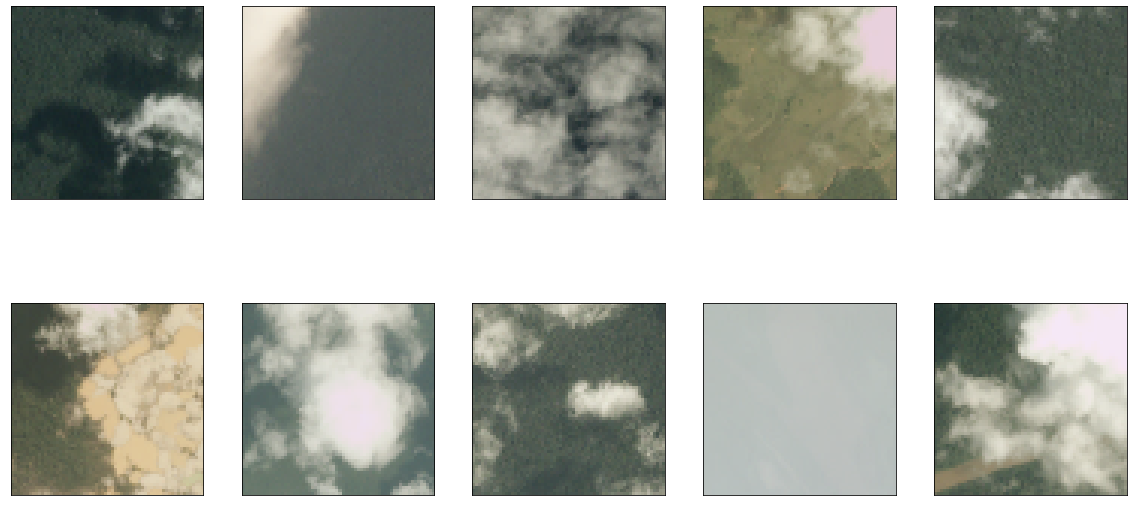

In [407]:
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(cloud_images_toplot[i+5])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(cloud_images_toplot[i+15])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [408]:
anom = torch.from_numpy(cloud_images)

<h4> Calcul de l'erreur pour les données normaux (No cloud) et les données repèsentant une anomalie (cloud)</h4>

In [409]:
train_losses_normal= []
train_losses_anom = []
for img in X_train:
    recon = model(img)
    loss = criterion(recon, img)
    train_losses_normal.append(loss.item())
    
for img in anom:
    recon = model(img)
    loss = criterion(recon, img)
    train_losses_anomaly.append(loss.item())    

<h4>Visualisation de la distribution de l'erreur entre l'image renconstruite et l'image originale pour les données anormaux (cloud images)</h4>

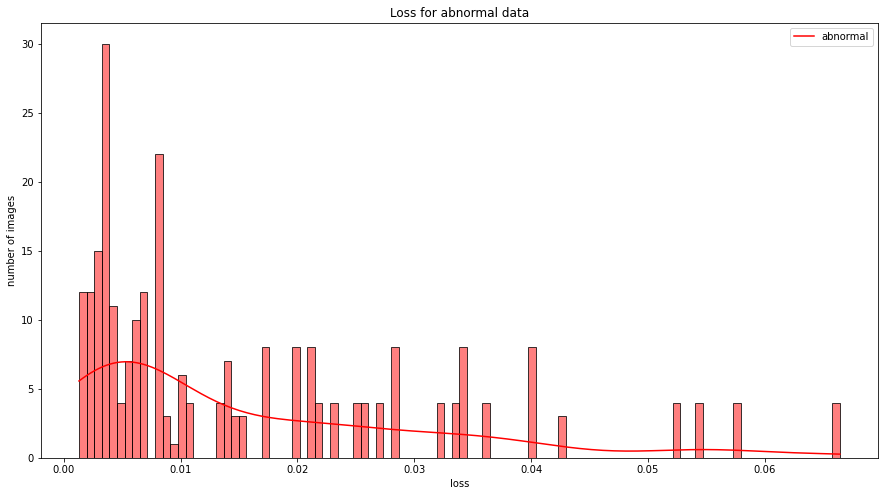

In [410]:
import seaborn as sns

plt.figure(figsize=(15,8))
sns.histplot(train_losses_anomaly,bins=100,kde=True, color='red')
plt.ylabel('number of images')
plt.xlabel('loss')
plt.legend(['abnormal'])
plt.title('Loss for abnormal data')
plt.show();

<h4>Visualisation de la distribution de l'erreur entre l'image renconstruite et l'image originale pour les données normaux (no cloud images)</h4>

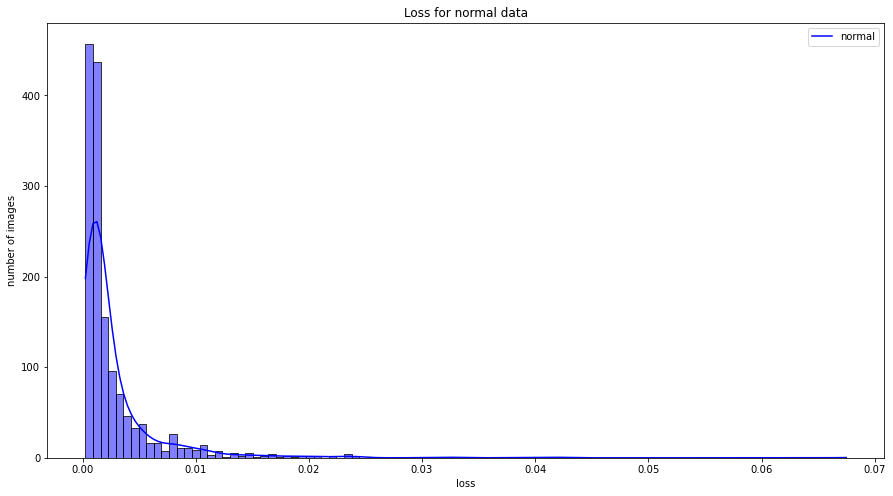

In [390]:
import seaborn as sns

plt.figure(figsize=(15,8))
sns.histplot(train_losses_normal,bins=100,kde=True, color='blue')
plt.ylabel('number of images')
plt.xlabel('loss')
plt.legend(['normal'])
plt.title('Loss for normal data')
plt.show();

<h4>Choix de la threshold d'erreur au dela de laquelle on detecte une anomalie</h4>

In [377]:
threshold = 0.02

<h4>Chargement de quelques images pour l'evaluation</h4>

In [378]:
test_images=[] 
test_images_toplot=[]
import os
img_list = os.listdir(r"C:\Users\oussa\Desktop\PPP\test_data")
for i in tqdm(img_list):
    img = tf.keras.preprocessing.image.load_img(r"C:\Users\oussa\Desktop\PPP\test_data"+'/'+str(i), target_size=(64,64,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255.
    test_images.append(img.flatten())
    test_images_toplot.append(img)
    

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 356.50it/s]


<h4>Prediction des resultats avec le modèle</h4>

In [379]:
test_images = np.array(test_images)
test_images = torch.from_numpy(test_images)
test_result=[]
plt.figure(figsize= (20,10))
for img in test_images:
    recon = model(img)
    loss = criterion(recon, img)
    if(loss > threshold):
        test_result.append("anomaly : CLOUD")
    else:
        test_result.append("normal : NO CLOUD")
    

<Figure size 1440x720 with 0 Axes>

<h4>Visualisation des resultats</h4>

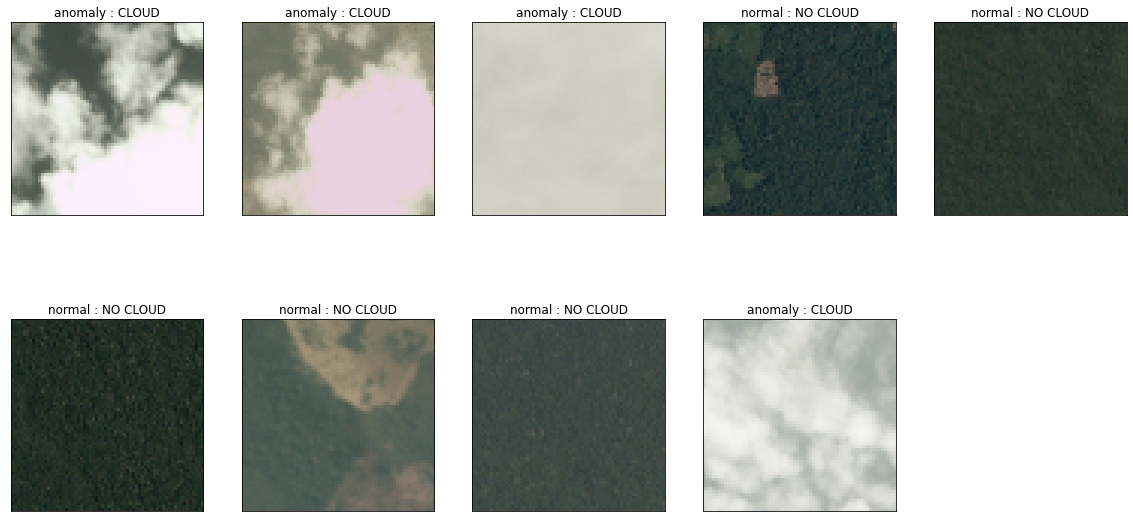

In [380]:
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    ax.title.set_text(test_result[i])
    plt.imshow(test_images_toplot[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+n)
    ax.title.set_text(test_result[i+n-1])
    plt.imshow(test_images_toplot[i+n-1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()